# Counting DL and DLT histories
### Cedric Chauve, 20/12/2019

### Abstract.
This notebook contains the code used to analyse our experimental results comparing ghe number of histories and reconciliations.

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import math
from trees import *

## Introduction

In this notebook, we consider 4 *models*: unranked DL (*uDL*), ranked Dl (*rDL*), unranked DLT (*uDLT*) and ranked DLT (*rDLT*). For each model, we generated $100$ species tree of size $k$ as follows: the caterpillar, a balanced binary tree, and the remaining $98$ species trees are generated at random under the uniform distribution, using the RANRUT algorithm as described in <a href="https://doi.org/10.1016/B978-0-12-519260-6.50035-8">Random Unlabeled Rooted Trees (RANRUT)</a>. 

Note that in this setting, for small values of $k$, some species trees are generated several times. Moreover, to do experiments in the two ranked models, for each species tree, we generated $10$ random rankings, again chosen under the uniform distribution using the algorithm for the random generation of linear extensions described in <a href="https://doi.org/10.1007/s00026-018-0371-7">On the Number of Unary-Binary Tree-Like Structures with Restrictions on the Unary Height</a>. 

Finally for each input (to be understood as a species tree $S$ of size $k$, together with a ranking if we are in a ranked model), we counted the number of histories and of reconciliations (in the chosen model) of size $n$. Our range parameter is $k \in [3,25]$ and $n\in [1,50]$.

We also sampled $10,000$ histories and reconciliations for the values $k=16,n=30$ in all four models.

In [2]:
# Parameters
# Number of species trees per size
NB_S_TREES    = 100
S_TREES_INDEX = [i for i in range(0,NB_S_TREES)]
# Objects
OBJECTS = ['H','R']
OBJECT2LEGEND = {'H':'Histories', 'R':'Reconciliations'}
# Evolutionary models
MODELS   = [('U','DL'),('U','DLT'),('R','DL'),('R','DLT')]
MODEL2LEGEND = {'U_DL': 'uDL model',
                'U_DLT': 'uDLT model',
                'R_DL': 'rDL model',
                'R_DLT': 'rDLT model'}
# Species tree sizes
K_MIN  = 3
K_MAX  = 25
K_LIST = [k for k in range(K_MIN,K_MAX+1)]

# Histories/reconciliations sizes
N_MIN = 1
N_MAX = 50
N_LIST = [n for n in range(N_MIN,N_MAX+1)]
# Paths to results
PREFIX_UNRANKED    = '../results/unranked'
PREFIX_RANKED      = '../results/ranked'
PREFIX_TREES       = '../results/trees'
PREFIX_SCORES      = '../results/samples'
# Rankings
R_MAX  = 10
R_LIST = [r for r in range(1,R_MAX+1)]
# Subset of the parameter space for more readable figures
K_LIST_REDUCED = [10,15,20,25]
N_LIST_REDUCED = [10,20,30,40,50]

In [3]:
# Reading the unranked trees
# Dictionary structure recording, for each value of k, the tree structures indexed by their ID 
TREES_dict = {k:{} for k in K_LIST}

def read_trees_file(fileName):
    treesFile = open(fileName,'r').readlines()
    for row in treesFile:
        if row[0] != '#':
            row1 = row.rstrip().split('\t')
            k = int(row1[0])
            treeIndex = int(row1[1])
            treeNewick = row1[2]
            tree = newick2Tree(treeNewick)
            labelTree(tree)
            TREES_dict[k][treeIndex] = tree
for k in K_LIST:
    read_trees_file(PREFIX_TREES+'_'+str(k))

In [4]:
# Reading the exact counting results
# Format: RESULTS_COUNTING_[object][model][s][n][tree_index] is 
# the list of the number of histories of size n for tree tree_index of size s in given model and object 
# the list is of size 1 if the tree is unranked

RESULTS_aux = {o:{m:{k:{n:{t:[] for t in S_TREES_INDEX} for n in N_LIST}  for k in K_LIST} for m in MODELS} for o in OBJECTS}

def read_counting_file(fileName,k):
    with gzip.open(fileName, 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0]!='#':
                objects   = row[2]
                model     = (row[3],row[4])
                treeIndex = int(row[1])
                row6      = row[6].split()
                for n in N_LIST:
                    RESULTS_aux[objects][model][k][n][treeIndex].append(int(row6[n-1]))
                   
    
for k in K_LIST:
    read_counting_file(PREFIX_UNRANKED+'_'+str(k)+'.gz',k)
    #read_counting_file(PREFIX_RANKED+'_'+str(k)+'.gz',k)

# Counting are stored ina data frame indexed by a triple (model,k,n) and storing the list of 1 (resp. 10) counting results
# in the unranked (resp. ranked) model.
RESULTS_COUNTING = pd.DataFrame.from_dict({(o,m,k,n): RESULTS_aux[o][m][k][n]
                                            for o in RESULTS_aux.keys()
                                            for m in RESULTS_aux[o].keys() 
                                            for k in RESULTS_aux[o][m].keys()
                                            for n in RESULTS_aux[o][m][k].keys()},
                                            orient='index')

## Estimating the growth factor in an arbitrary model
We estimate the growth factor from the various counting sequences using the formula
$$\alpha_S \simeq e^{\left(\frac{\ln\left(n^{3/2}h_S(n)\right)}{n}\right)}.$$

In [5]:
def estimate_growth_constant_1(o,m,k,n,res):
    RESULTS_COUNTING_o_m_k_n  = []
    RESULTS_COUNTING_o_m_k_n1 = []
    RESULTS_COUNTING_o_m_k_n_aux  = res.loc[(o,m,k,n)]    # Number of histories/rec of size n indexed by tree
    RESULTS_COUNTING_o_m_k_n1_aux = res.loc[(o,m,k,n-1)]  # Number of histories/rec of size n-1 indexed by tree
    for i in RESULTS_COUNTING_o_m_k_n_aux.keys():
        RESULTS_COUNTING_o_m_k_n  += RESULTS_COUNTING_o_m_k_n_aux[i]
        RESULTS_COUNTING_o_m_k_n1 += RESULTS_COUNTING_o_m_k_n1_aux[i]
    RESULTS_COUNTING_o_m_k_n_EXP_GROWTH = []
    for i in range(len(RESULTS_COUNTING_o_m_k_n)):
        RESULTS_COUNTING_o_m_k_n_EXP_GROWTH.append(RESULTS_COUNTING_o_m_k_n[i]/RESULTS_COUNTING_o_m_k_n1[i])
    return(RESULTS_COUNTING_o_m_k_n_EXP_GROWTH)

RESULTS_EST_ASYMPTOTICS_H_UDL  = pd.DataFrame({k: estimate_growth_constant_1('H',('U','DL'),k,50,RESULTS_COUNTING) for k in K_LIST})
#RESULTS_EST_ASYMPTOTICS_H_RDL  = pd.DataFrame({k: estimate_growth_constant_1('H',('R','DL'),k,50,RESULTS_COUNTING) for k in K_LIST})
RESULTS_EST_ASYMPTOTICS_H_UDLT = pd.DataFrame({k: estimate_growth_constant_1('H',('U','DLT'),k,50,RESULTS_COUNTING) for k in K_LIST})
#RESULTS_EST_ASYMPTOTICS_H_RDLT = pd.DataFrame({k: estimate_growth_constant_1('H',('R','DLT'),k,50,RESULTS_COUNTING) for k in K_LIST})

RESULTS_EST_ASYMPTOTICS_R_UDL  = pd.DataFrame({k: estimate_growth_constant_1('R',('U','DL'),k,50,RESULTS_COUNTING) for k in K_LIST})
#RESULTS_EST_ASYMPTOTICS_R_RDL  = pd.DataFrame({k: estimate_growth_constant_1('R',('R','DL'),k,50,RESULTS_COUNTING) for k in K_LIST})
RESULTS_EST_ASYMPTOTICS_R_UDLT = pd.DataFrame({k: estimate_growth_constant_1('R',('U','DLT'),k,50,RESULTS_COUNTING) for k in K_LIST})
#RESULTS_EST_ASYMPTOTICS_R_RDLT = pd.DataFrame({k: estimate_growth_constant_1('R',('R','DLT'),k,50,RESULTS_COUNTING) for k in K_LIST})

<Figure size 432x288 with 0 Axes>

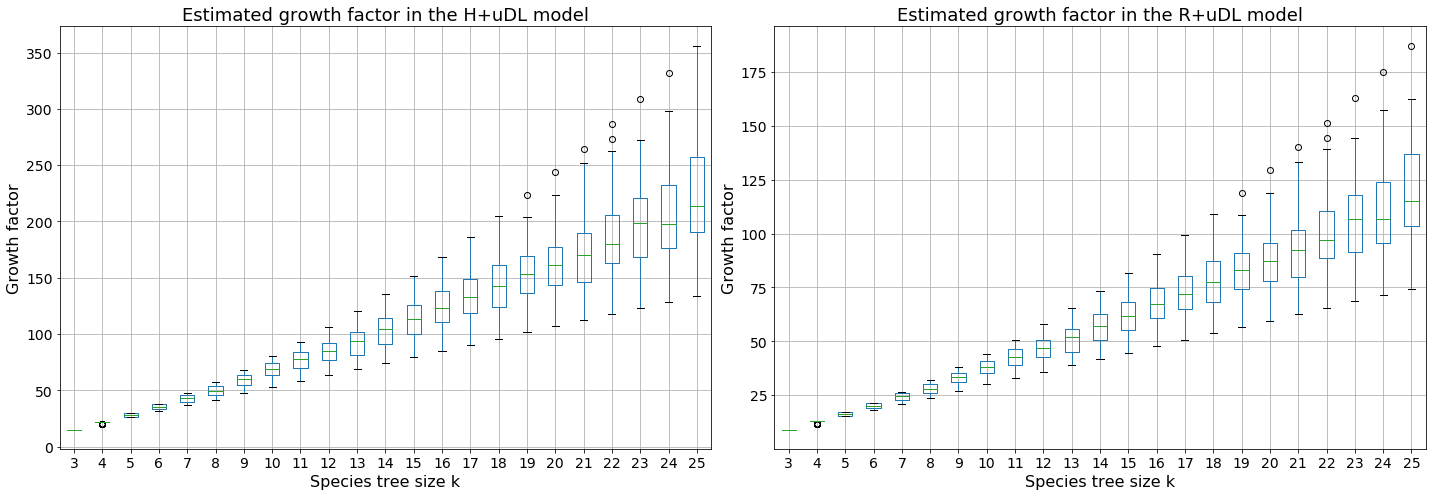

In [6]:
# Figure 1
plt.figure()
fig_asympta, ax_asympta = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

RESULTS_EST_ASYMPTOTICS_H_UDL.plot(ax=ax_asympta[0], kind='box', grid=True, return_type='axes', title='Estimated growth factor in the H+uDL model', fontsize=14)
ax_asympta[0].title.set_size(18)
ax_asympta[0].set_ylabel('Growth factor', fontsize=16)
ax_asympta[0].set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_H_U_DL.png')

RESULTS_EST_ASYMPTOTICS_R_UDL.plot(ax=ax_asympta[1], kind='box', grid=True, return_type='axes', title='Estimated growth factor in the R+uDL model', fontsize=14)
ax_asympta[1].title.set_size(18)
ax_asympta[1].set_ylabel('Growth factor', fontsize=16)
ax_asympta[1].set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_R_U_DL.png')

fig_asympta.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

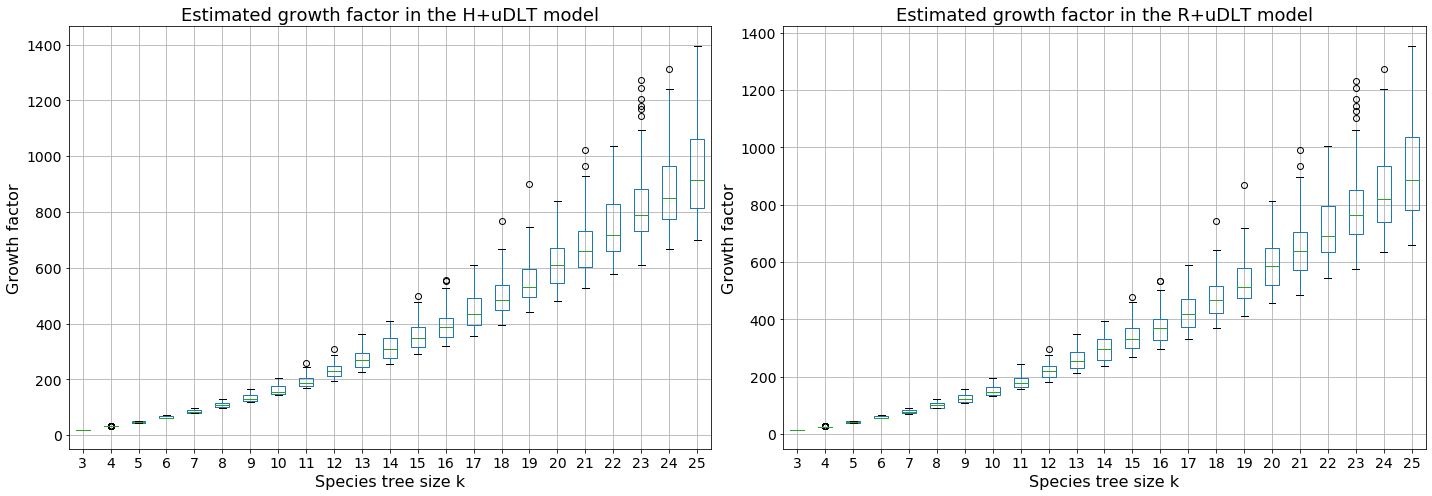

In [7]:
# Figure 2
plt.figure()
fig_asymptb, ax_asymptb = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

RESULTS_EST_ASYMPTOTICS_H_UDLT.plot(ax=ax_asymptb[0], kind='box', grid=True, return_type='axes', title='Estimated growth factor in the H+uDLT model', fontsize=14)
ax_asymptb[0].title.set_size(18)
ax_asymptb[0].set_ylabel('Growth factor', fontsize=16)
ax_asymptb[0].set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_H_U_DLT.png')

RESULTS_EST_ASYMPTOTICS_R_UDLT.plot(ax=ax_asymptb[1], kind='box', grid=True, return_type='axes', title='Estimated growth factor in the R+uDLT model', fontsize=14)
ax_asymptb[1].title.set_size(18)
ax_asymptb[1].set_ylabel('Growth factor', fontsize=16)
ax_asymptb[1].set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_R_U_DLT.png')

fig_asymptb.tight_layout()
plt.show()

## Ratio DLT-objects / DL-objects

Next, we compute the ratio between the number of DLT-objects and the number of DL-objects in the ranked and unranked models.

In [8]:
RESULTS_aux = {o:{k:{n:{t:0 for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED} for o in OBJECTS}
for o in OBJECTS:
    for k in K_LIST_REDUCED:
        for n in N_LIST_REDUCED:
            for t in S_TREES_INDEX:
                odlth = RESULTS_COUNTING.at[(o,('U','DLT'),k,n),t][0]
                odlh  = RESULTS_COUNTING.at[(o,('U','DL'),k,n),t][0]
                RESULTS_aux[o][k][n][t] = odlth/odlh
                
RATIOS_H_UDLT_UDL = pd.DataFrame.from_dict({(k,n): RESULTS_aux['H'][k][n]
                                            for k in RESULTS_aux['H'].keys() 
                                            for n in RESULTS_aux['H'][k].keys()},
                                            orient='index')
RATIOS_R_UDLT_UDL = pd.DataFrame.from_dict({(k,n): RESULTS_aux['R'][k][n]
                                            for k in RESULTS_aux['R'].keys() 
                                            for n in RESULTS_aux['R'][k].keys()},
                                            orient='index')

<Figure size 432x288 with 0 Axes>

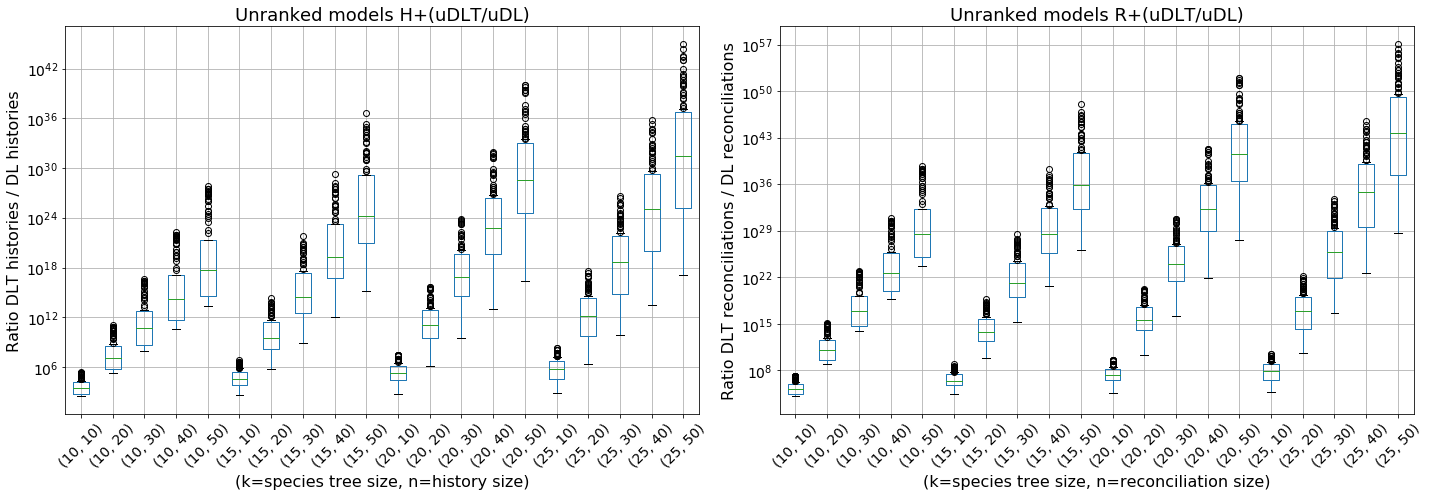

In [9]:
# Figure 3

plt.figure()
fig_ratioa, ax_ratioa = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

RATIOS_H_UDLT_UDL.transpose().plot(ax=ax_ratioa[0], kind='box', grid=True, return_type='axes', title='Unranked models H+(uDLT/uDL)', fontsize=14, rot=45)
ax_ratioa[0].title.set_size(18)
ax_ratioa[0].set_yscale('log')
ax_ratioa[0].set_ylabel('Ratio DLT histories / DL histories', fontsize=16)
ax_ratioa[0].set_xlabel('(k=species tree size, n=history size)', fontsize=16)
plt.savefig('figures/ratio_H_UDLT_UDL_per_tree.png')

RATIOS_R_UDLT_UDL.transpose().plot(ax=ax_ratioa[1], kind='box', grid=True, return_type='axes', title='Unranked models R+(uDLT/uDL)', fontsize=14, rot=45)
ax_ratioa[1].title.set_size(18)
ax_ratioa[1].set_yscale('log')
ax_ratioa[1].set_ylabel('Ratio DLT reconciliations / DL reconciliations', fontsize=16)
ax_ratioa[1].set_xlabel('(k=species tree size, n=reconciliation size)', fontsize=16)
plt.savefig('figures/ratio_R_UDLT_UDL_per_tree.png')

fig_ratioa.tight_layout()
plt.show()

## Ratio histories / reconciliations

Last, we compute the ratio between the number of histories and the number of reconciliations in all models.

In [10]:
RESULTS_aux = {m:{k:{n:{t:0 for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED} for m in MODELS}
for m in [('U','DL'),('U','DLT')]:
    for k in K_LIST_REDUCED:
        for n in N_LIST_REDUCED:
            for t in S_TREES_INDEX:
                mh = RESULTS_COUNTING.at[('H',m,k,n),t][0]
                mr = RESULTS_COUNTING.at[('R',m,k,n),t][0]
                RESULTS_aux[m][k][n][t] = mh/mr
                
RATIOS_HR_UDL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[('U','DL')][k][n]
                                            for k in RESULTS_aux[('U','DL')].keys() 
                                            for n in RESULTS_aux[('U','DL')][k].keys()},
                                            orient='index')
RATIOS_HR_UDLT = pd.DataFrame.from_dict({(k,n): RESULTS_aux[('U','DLT')][k][n]
                                            for k in RESULTS_aux[('U','DLT')].keys() 
                                            for n in RESULTS_aux[('U','DLT')][k].keys()},
                                            orient='index')


<Figure size 432x288 with 0 Axes>

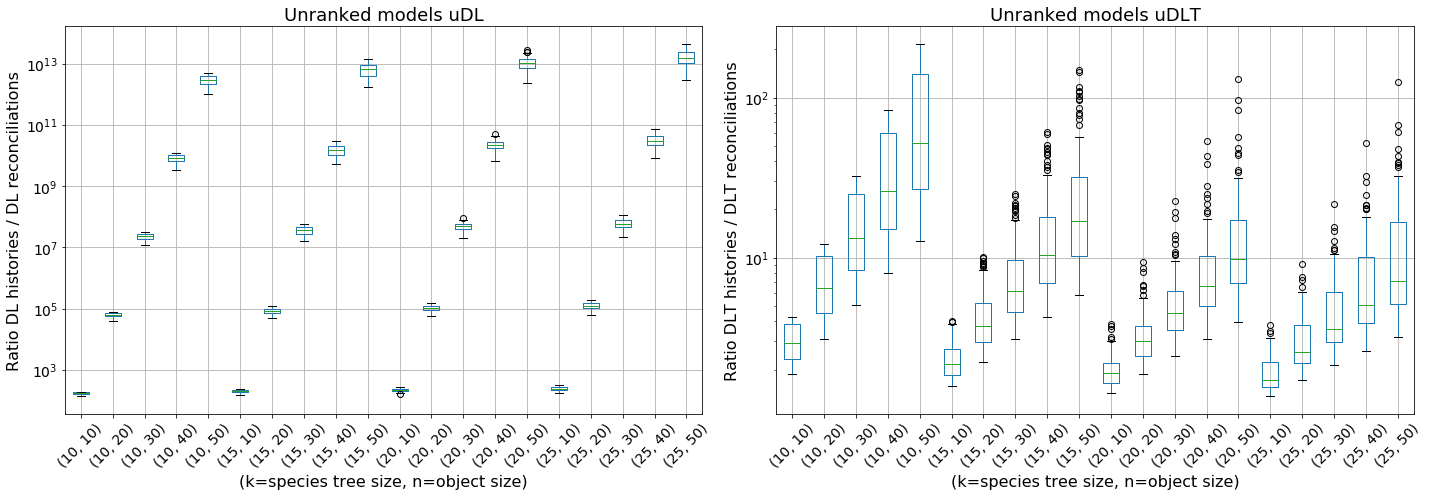

In [11]:
# Figure 4

plt.figure()
fig_ratiob, ax_ratiob = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

RATIOS_HR_UDL.transpose().plot(ax=ax_ratiob[0], kind='box', grid=True, return_type='axes', title='Unranked models uDL', fontsize=14, rot=45)
ax_ratiob[0].title.set_size(18)
ax_ratiob[0].set_yscale('log')
ax_ratiob[0].set_ylabel('Ratio DL histories / DL reconciliations', fontsize=16)
ax_ratiob[0].set_xlabel('(k=species tree size, n=object size)', fontsize=16)
plt.savefig('figures/ratio_HR_UDL_per_tree.png')

RATIOS_HR_UDLT.transpose().plot(ax=ax_ratiob[1], kind='box', grid=True, return_type='axes', title='Unranked models uDLT', fontsize=14, rot=45)
ax_ratiob[1].title.set_size(18)
ax_ratiob[1].set_yscale('log')
ax_ratiob[1].set_ylabel('Ratio DLT histories / DLT reconciliations', fontsize=16)
ax_ratiob[1].set_xlabel('(k=species tree size, n=object size)', fontsize=16)
plt.savefig('figures/ratio_HR_UDLT_per_tree.png')

fig_ratiob.tight_layout()
plt.show()

## Score distribution from sampling

For each of the three models uDL, uDLT, we considered $(k,n)=(16,30)$ and we generated 50 random species trees (plus ranking in the rDLT model) and $10,000$ random reconciliations. We show the distribution of the number of duplications, losses, HGTs and score (defined as the sum of the three kinds of events).

In [12]:
def read_scores(k,n,m,o,s):
    RESULTS_SCORES_aux  = {}
    with gzip.open(PREFIX_SCORES+'_'+o+'_'+str(k)+'_'+str(n)+'_'+m+'.gz', 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0] == '#': #Species tree
                treeIndex = int(row[0].replace('# S_',''))
                RESULTS_SCORES_aux[treeIndex]  = {'D':[], 'L':[], 'T':[], 'A':[]}
                sampleIndex = 0
            else:
                row1 = row[0].rstrip().split(' ')
                D = int(row1[k].split(':')[1])
                L = int(row1[k+1].split(':')[1])
                T = int(row1[k+2].split(':')[1])
                RESULTS_SCORES_aux[treeIndex]['D'].append(D)
                RESULTS_SCORES_aux[treeIndex]['L'].append(L)
                RESULTS_SCORES_aux[treeIndex]['T'].append(T)
                RESULTS_SCORES_aux[treeIndex]['A'].append(D+L+T)
                sampleIndex += 1
                
    RESULTS_SCORES = pd.DataFrame.from_dict({(t): RESULTS_SCORES_aux[t]
                                            for t in RESULTS_SCORES_aux.keys()},
                                            orient='index')
    return(RESULTS_SCORES)

In [13]:
SCORES_H_16_30_uDL  = read_scores(16,30,'UDL','H',10000)
SCORES_H_16_30_uDLT = read_scores(16,30,'UDLT','H',10000)
SCORES_R_16_30_uDL  = read_scores(16,30,'UDL','R',10000)
SCORES_R_16_30_uDLT = read_scores(16,30,'UDLT','R',10000)

In [14]:
from operator import truediv 

SCORES_R_uDL  = []
SCORES_R_uDLT = []

RATIO_R_DUP_SCORE_uDL  = []
RATIO_R_LOSS_SCORE_uDL = []
RATIO_R_LOSS_DUP_uDL   = []
RATIO_R_DUP_SCORE_uDLT  = []
RATIO_R_HGT_SCORE_uDLT  = []
RATIO_R_LOSS_SCORE_uDLT = []

uDL_NBTREES = len(SCORES_R_16_30_uDL)
for t in range(uDL_NBTREES):
    SCORES_R_uDL += SCORES_R_16_30_uDL.iloc[t]['A']
    RATIO_R_DUP_SCORE_uDL  += list(map(truediv,SCORES_R_16_30_uDL.iloc[t]['D'],SCORES_R_16_30_uDL.iloc[t]['A']))
    RATIO_R_LOSS_SCORE_uDL += list(map(truediv,SCORES_R_16_30_uDL.iloc[t]['L'],SCORES_R_16_30_uDL.iloc[t]['A']))
    RATIO_R_LOSS_DUP_uDL   += list(map(truediv,SCORES_R_16_30_uDLT.iloc[t]['D'],SCORES_R_16_30_uDLT.iloc[t]['L']))

uDLT_NBTREES = len(SCORES_R_16_30_uDL)
for t in range(uDLT_NBTREES):
    SCORES_R_uDLT += SCORES_R_16_30_uDLT.iloc[t]['A']
    RATIO_R_DUP_SCORE_uDLT  += list(map(truediv,SCORES_R_16_30_uDLT.iloc[t]['D'],SCORES_R_16_30_uDLT.iloc[t]['A']))
    RATIO_R_HGT_SCORE_uDLT  += list(map(truediv,SCORES_R_16_30_uDLT.iloc[t]['T'],SCORES_R_16_30_uDLT.iloc[t]['A']))
    RATIO_R_LOSS_SCORE_uDLT += list(map(truediv,SCORES_R_16_30_uDLT.iloc[t]['L'],SCORES_R_16_30_uDL.iloc[t]['A']))
    
SCORES_H_uDL  = []
SCORES_H_uDLT = []

RATIO_H_DUP_SCORE_uDL  = []
RATIO_H_LOSS_SCORE_uDL = []
RATIO_H_LOSS_DUP_uDL   = []
RATIO_H_DUP_SCORE_uDLT  = []
RATIO_H_HGT_SCORE_uDLT  = []
RATIO_H_LOSS_SCORE_uDLT = []

uDL_NBTREES = len(SCORES_H_16_30_uDL)
for t in range(uDL_NBTREES):
    SCORES_H_uDL += SCORES_H_16_30_uDL.iloc[t]['A']
    RATIO_H_DUP_SCORE_uDL  += list(map(truediv,SCORES_H_16_30_uDL.iloc[t]['D'],SCORES_H_16_30_uDL.iloc[t]['A']))
    RATIO_H_LOSS_SCORE_uDL += list(map(truediv,SCORES_H_16_30_uDL.iloc[t]['L'],SCORES_H_16_30_uDL.iloc[t]['A']))
    RATIO_H_LOSS_DUP_uDL   += list(map(truediv,SCORES_H_16_30_uDLT.iloc[t]['D'],SCORES_H_16_30_uDLT.iloc[t]['L']))

uDLT_NBTREES = len(SCORES_H_16_30_uDL)
for t in range(uDLT_NBTREES):
    SCORES_H_uDLT += SCORES_H_16_30_uDLT.iloc[t]['A']
    RATIO_H_DUP_SCORE_uDLT  += list(map(truediv,SCORES_H_16_30_uDLT.iloc[t]['D'],SCORES_H_16_30_uDLT.iloc[t]['A']))
    RATIO_H_HGT_SCORE_uDLT  += list(map(truediv,SCORES_H_16_30_uDLT.iloc[t]['T'],SCORES_H_16_30_uDLT.iloc[t]['A']))
    RATIO_H_LOSS_SCORE_uDLT += list(map(truediv,SCORES_H_16_30_uDLT.iloc[t]['L'],SCORES_H_16_30_uDL.iloc[t]['A']))
    
NB_BINS = 26 # Number of histograms bins

<Figure size 432x288 with 0 Axes>

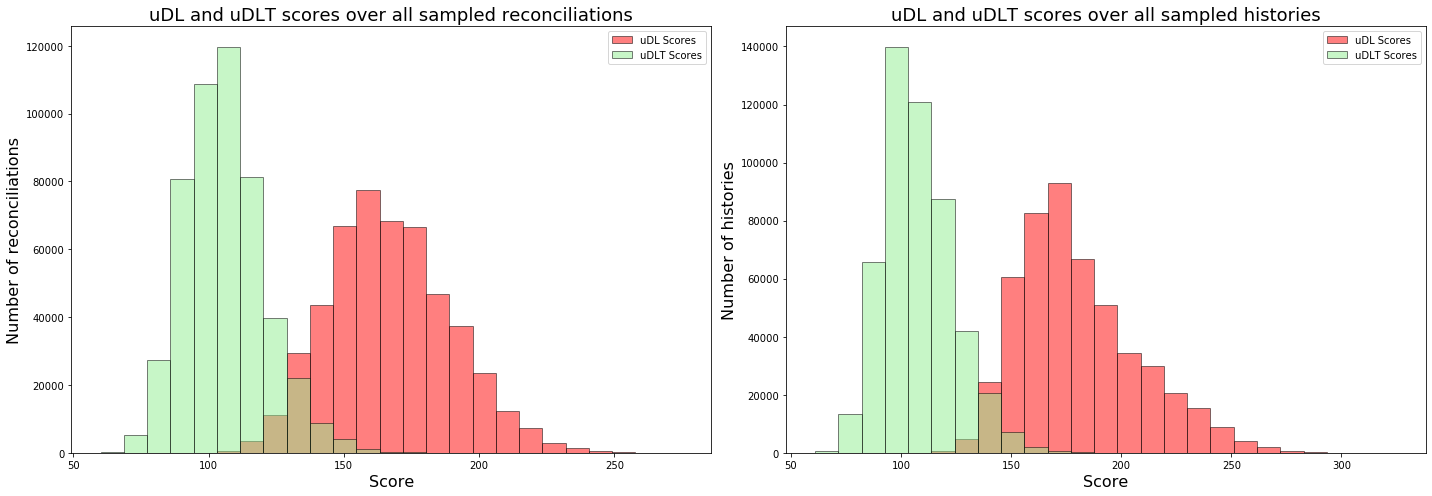

In [15]:
bins_R_SCORES = np.linspace(min(min(SCORES_R_uDL),min(SCORES_R_uDLT)),max(max(SCORES_R_uDL),max(SCORES_R_uDLT)),NB_BINS)
bins_H_SCORES = np.linspace(min(min(SCORES_H_uDL),min(SCORES_H_uDLT)),max(max(SCORES_H_uDL),max(SCORES_H_uDLT)),NB_BINS)

plt.figure()
fig_samplea, ax_samplea = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

#ax_samplea[0]  = fig.add_subplot(111)    
ax_samplea[0].hist(SCORES_R_uDL, bins=bins_R_SCORES, ec='black', color='red', label='uDL Scores', alpha=0.5) 
ax_samplea[0].hist(SCORES_R_uDLT, bins=bins_R_SCORES, ec='black', color='lightgreen', label='uDLT Scores', alpha=0.5) 
ax_samplea[0].set_title('uDL and uDLT scores over all sampled reconciliations', fontsize=14)
ax_samplea[0].title.set_size(18)
ax_samplea[0].legend(loc='upper right')
ax_samplea[0].set_xlabel('Score', fontsize=16)
ax_samplea[0].set_ylabel('Number of reconciliations', fontsize=16)
plt.savefig('figures/Scores_R_16_30_uDL_uDLT.png')

#ax_samplea[1]  = fig.add_subplot(111)    
ax_samplea[1].hist(SCORES_H_uDL, bins=bins_H_SCORES, ec='black', color='red', label='uDL Scores', alpha=0.5) 
ax_samplea[1].hist(SCORES_H_uDLT, bins=bins_H_SCORES, ec='black', color='lightgreen', label='uDLT Scores', alpha=0.5) 
ax_samplea[1].set_title('uDL and uDLT scores over all sampled histories', fontsize=14)
ax_samplea[1].title.set_size(18)
ax_samplea[1].legend(loc='upper right')
ax_samplea[1].set_xlabel('Score', fontsize=16)
ax_samplea[1].set_ylabel('Number of histories', fontsize=16)
plt.savefig('figures/Scores_H_16_30_uDL_uDLT.png')

fig_samplea.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

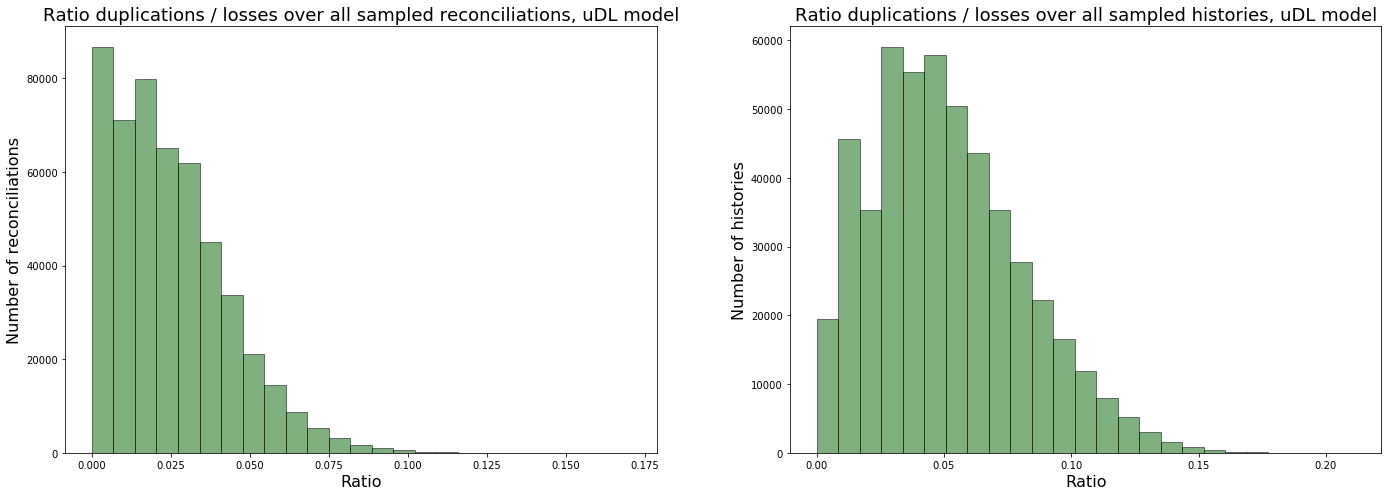

In [16]:
bins_R_LOSS_SCORE_uDL = np.linspace(0.7,1,NB_BINS)
bins_R_DUP_SCORE_uDL = np.linspace(0,0.3,NB_BINS)
bins_R_RATIO_LOSS_DUP_uDL = np.linspace(min(RATIO_R_LOSS_DUP_uDL),max(RATIO_R_LOSS_DUP_uDL),NB_BINS)
bins_H_RATIO_LOSS_DUP_uDL = np.linspace(min(RATIO_H_LOSS_DUP_uDL),max(RATIO_H_LOSS_DUP_uDL),NB_BINS)

plt.figure()
fig_sampleb, ax_sampleb = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

#ax_sampleb[0]  = fig.add_subplot(111)    
ax_sampleb[0].hist(RATIO_R_LOSS_DUP_uDL, bins=bins_R_RATIO_LOSS_DUP_uDL, ec='black', color='darkgreen', alpha=0.5) 
ax_sampleb[0].set_title('Ratio duplications / losses over all sampled reconciliations, uDL model', fontsize=14)
ax_sampleb[0].title.set_size(18)
ax_sampleb[0].set_xlabel('Ratio', fontsize=16)
ax_sampleb[0].set_ylabel('Number of reconciliations', fontsize=16)
plt.savefig('figures/DupLoss_R_16_30_uDL.png')

#ax_sampleb[1]  = fig.add_subplot(111)    
ax_sampleb[1].hist(RATIO_H_LOSS_DUP_uDL, bins=bins_H_RATIO_LOSS_DUP_uDL, ec='black', color='darkgreen', alpha=0.5) 
ax_sampleb[1].set_title('Ratio duplications / losses over all sampled histories, uDL model', fontsize=14)
ax_sampleb[1].title.set_size(18)
ax_sampleb[1].set_xlabel('Ratio', fontsize=16)
ax_sampleb[1].set_ylabel('Number of histories', fontsize=16)
plt.savefig('figures/DupLoss_H_16_30_uDL.png')

fig_sampleb.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

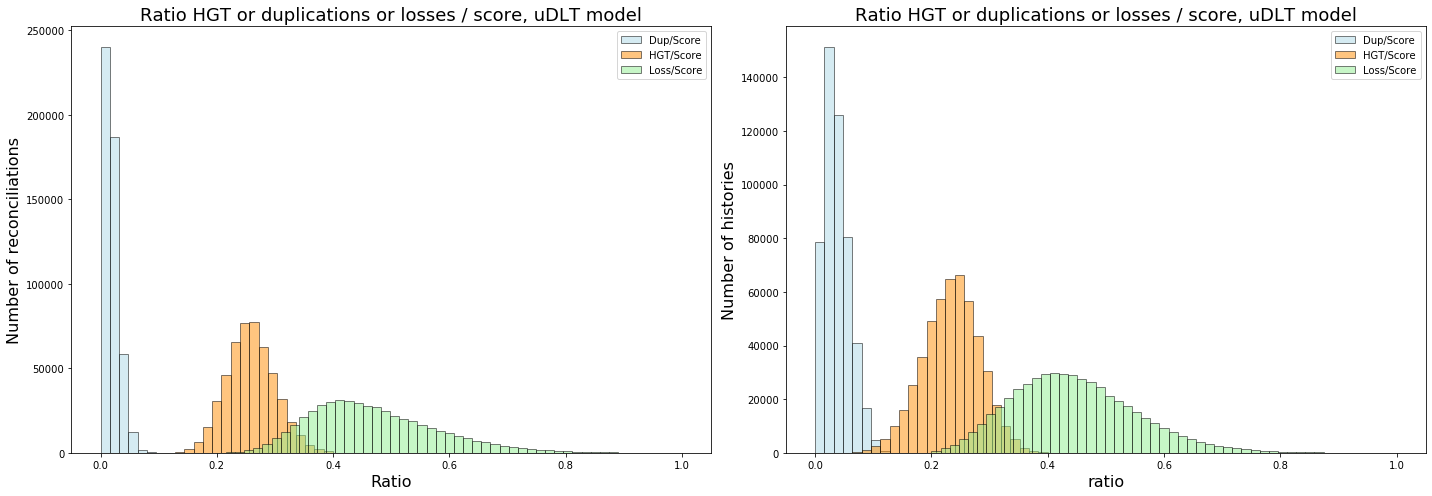

In [17]:
plt.figure()
fig_samplec, ax_samplec = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

#ax_samplec[0]  = fig.add_subplot(111)    
ax_samplec[0].hist(RATIO_R_DUP_SCORE_uDLT,  bins = np.linspace(0,0.4,NB_BINS), ec='black', color='lightblue', label = 'Dup/Score', alpha=0.5) 
ax_samplec[0].hist(RATIO_R_HGT_SCORE_uDLT,  bins = np.linspace(0,0.4,NB_BINS), ec='black', color='darkorange', label = 'HGT/Score', alpha=0.5) 
ax_samplec[0].hist(RATIO_R_LOSS_SCORE_uDLT,  bins = np.linspace(0.2,1,2*NB_BINS), ec='black', color='lightgreen', label = 'Loss/Score', alpha=0.5) 
ax_samplec[0].set_title('Ratio HGT or duplications or losses / score, uDLT model', fontsize=14)
ax_samplec[0].title.set_size(18)
ax_samplec[0].legend(loc='upper right')
ax_samplec[0].set_xlabel('Ratio', fontsize=16)
ax_samplec[0].set_ylabel('Number of reconciliations', fontsize=16)
plt.savefig('figures/HGTDupLoss_vs_score_R_16_30_uDLT.png')

#ax_samplec[1]  = fig.add_subplot(111)    
ax_samplec[1].hist(RATIO_H_DUP_SCORE_uDLT,  bins = np.linspace(0,0.4,NB_BINS), ec='black', color='lightblue', label = 'Dup/Score', alpha=0.5) 
ax_samplec[1].hist(RATIO_H_HGT_SCORE_uDLT,  bins = np.linspace(0,0.4,NB_BINS), ec='black', color='darkorange', label = 'HGT/Score', alpha=0.5) 
ax_samplec[1].hist(RATIO_H_LOSS_SCORE_uDLT,  bins = np.linspace(0.2,1,2*NB_BINS), ec='black', color='lightgreen', label = 'Loss/Score', alpha=0.5) 
ax_samplec[1].set_title('Ratio HGT or duplications or losses / score, uDLT model', fontsize=14)
ax_samplec[1].title.set_size(18)
ax_samplec[1].legend(loc='upper right')
ax_samplec[1].set_xlabel('ratio', fontsize=16)
ax_samplec[1].set_ylabel('Number of histories', fontsize=16)
plt.savefig('figures/HGTDupLoss_vs_score_H_16_30_uDLT.png')

fig_samplec.tight_layout()
plt.show()